# OkNLP

In [1]:
import warnings

from sklearn.linear_model import LogisticRegression

from utils.categorize_demographics import *
from utils.clean_up import clean_up
from utils.distinctive_tokens import log_odds_ratio
from utils.lexical_features import *
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.plotting import lollipop
from utils.splits import *
from utils.text_representation import feature_vectors


warnings.filterwarnings('ignore')

%matplotlib inline

## Data

In [2]:
df = pd.read_csv('data/profiles.20120630.csv')

essay_list = ['essay0', 'essay4']
df_0, df_4 = clean_up(df, essay_list)

df_0 = recategorize(df_0)
df_4 = recategorize(df_4)

## Lexical

Based on the universal tagset of Petrov, Das, & McDonald ([link](https://github.com/slavpetrov/universal-pos-tags)).

```
ADJ - adjectives
ADP - adpositions (prepositions and postpositions)
ADV - adverbs
CONJ - conjunctions
DET - determiners
NOUN - nouns (common and proper)
NUM - cardinal numbers
PART - particles or other function words
PRON - pronouns
PUNCT - punctuation
VERB - verbs (all tenses and modes)
X - other: foreign words, typos, abbreviations
```

spaCy-specific information: https://spacy.io/docs#token-postags.

In [3]:
pos = pos_df(df_0.essay0)
pos_norm = pos_normalize(pos)

### Essay Length

In [4]:
pos['n_tokens'] = pos.sum(axis=1)
pos_by_split(df_0, pos, 'sex', ['n_tokens'], print_levels=True)

Levels (in order): ['F' 'M']

n_tokens
[means] 'a': 149.58946578 'b': 138.72696526
p-values:
  [permutation]: 0.0
  [classical]:   0.0



### Profanity and Slang

In [5]:
profane = load_words('data/profane.txt')
profanity = pd.DataFrame(contains(profane, df_0.essay0),
                         columns=['profanity'])
print(profanity.profanity.sum() / profanity.shape[0])
pos_by_split(df_0, profanity, 'sex', ['profanity'])

0.0600098191019
profanity
[means] 'a': 0.05815862 'b': 0.06125739
p-values:
  [permutation]: 0.1439
  [classical]:   0.1390202



In [6]:
slang = load_words('data/slang.txt')
slang = pd.DataFrame(contains(slang, df_0.essay0),
                     columns=['slang'])
print(slang.slang.sum() / slang.shape[0])
pos_by_split(df_0, slang, 'sex', ['slang'])

0.559084557574
slang
[means] 'a': 0.5411097 'b': 0.57119828
p-values:
  [permutation]: 0.0
  [classical]:   0.0



### Adjectives, Nouns, and Verbs

In [7]:
pos_by_split(df_0, pos_norm, 'sex', ['ADJ', 'NOUN', 'VERB'])

ADJ
[means] 'a': 0.10614445 'b': 0.10162557
p-values:
  [permutation]: 0.0
  [classical]:   0.0

NOUN
[means] 'a': 0.18651103 'b': 0.18868403
p-values:
  [permutation]: 0.0
  [classical]:   3.163e-05

VERB
[means] 'a': 0.18277245 'b': 0.18272425
p-values:
  [permutation]: 0.9122
  [classical]:   0.90974631



### Tokens

In [8]:
f = subset_df(df_0, 'sex', ['F'])
m = subset_df(df_0, 'sex', ['M'])

tagged_f = tag_corpus(f.essay0)
tagged_m = tag_corpus(m.essay0)

#### Adjectives

In [9]:
top_terms(tagged_f, tagged_m, 'ADJ', diff_prop, 15)

my | happy | independent | favorite | sweet | silly | important | passionate | warm | amazing | beautiful | adventurous | creative | loyal | social

that | nice | more | few | other | most | its | cool | interesting | your | easy | good | which | much | last


In [10]:
top_terms(tagged_f, tagged_m, 'ADJ', log_odds_ratio, 10)

independent | sweet | my | sassy | silly | happy | warm | favorite | girly | fabulous

nice | cool | its | that | few | interesting | martial | most | masculine | more


#### Nouns

In [11]:
top_terms(tagged_f, tagged_m, 'NOUN', log_odds_ratio, 10)

girl | family | who | yoga | men | gal | heels | love | dancing | friends

guy | computer | engineer | guitar | sports | software | women | video | technology | geek


#### Verbs

In [12]:
top_terms(tagged_f, tagged_m, 'VERB', log_odds_ratio, 10)

love | am | laugh | laughing | dancing | adore | loving | dance | appreciate | being

m | was | play | playing | laid | 'll | working | hit | moved | been


## Semantic

In [13]:
specs = {'stop_words' : 'english', 'ngram_range' : (1, 3), 'min_df' : 0.005}

### Essay 0

#### Text Representation

The benefit of the spaCy tokenizer is that it separates multiple (repeated) punctuation into individual tokens. This means it deletes groups of symbols (e.g., "..." or "!!"). A potential drawback, at least for "ease" of interpretability, is that the spaCy tokenizer splits contractions. However, this is convention in NLP. Not that both spaCy and happyfuntokenizer keep emoticons.

In [14]:
counts, tfidf, vocab = feature_vectors(df_0.essay0, specs)

#### Clustering

In [15]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
people | new people | new | meet | meet new | meet new people | meeting | meeting new | meeting new people | looking meet | looking meet new | love meeting | love meeting new | new friends | meet people | like meet | people 'm | love meet | friends | enjoy meeting | interesting | 'm looking meet | city | interesting people | meeting people | interested | want meet | interested meeting | 'm new | people love | experiences | just moved | online | dating | site | new experiences | people like | cool | outgoing | hang | new places | hoping | excited | make new | recently | make new friends | people n't | moved | people make | :)

Group 1:
san | francisco | san francisco | moved san | moved san francisco | city | living san | living san francisco | living | moved | just moved san | live san | live | diego | native | san diego | lived san | grew | lived san francisco | lived | originally | years | recently | year | raised san | home | york | currently | new york | born raised san

In [16]:
df_0['group'] = nmf_labels(tfidf, k=K)

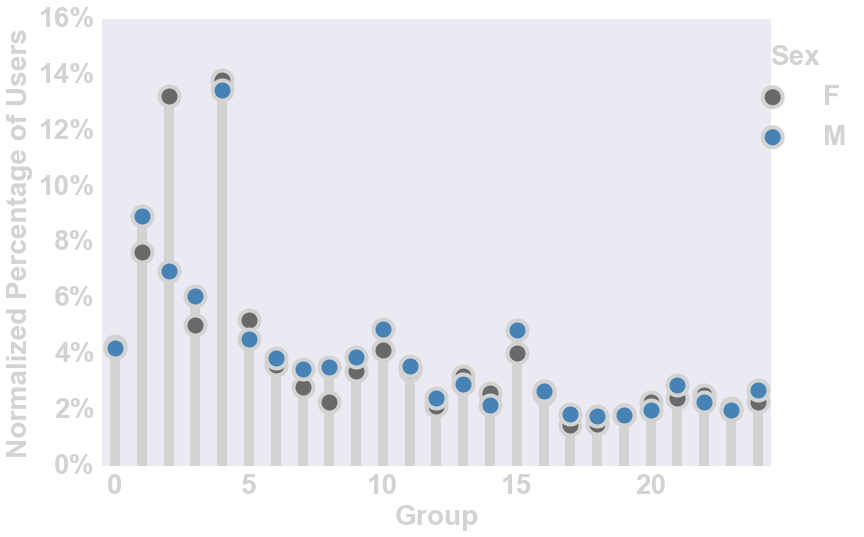

In [17]:
demog = 'sex'
subset = subset_df(df_0, demog, ['F', 'M'])
grouped = group_pct(subset, demog)
lollipop(grouped, demog, ['DimGray', 'SteelBlue'])

### Essay 4

#### Text Representation

The benefit of the spaCy tokenizer is that it separates multiple (repeated) punctuation into individual tokens. This means it deletes groups of symbols (e.g., "..." or "!!"). A potential drawback, at least for "ease" of interpretability, is that the spaCy tokenizer splits contractions. However, this is convention in NLP. Not that both spaCy and happyfuntokenizer keep emoticons.

In [18]:
counts, tfidf, vocab = feature_vectors(df_4.essay4, specs)

#### Clustering

In [19]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
like | music like | movies like | really | really like | stuff | food like | things | like music | books like | like movies | n't like | like food | movies | lot | stuff like | like lot | like read | kind | comedies | like good | music | good | shows like | things like | like books | think | like reading | make | different | like watch | especially | old | like kinds | feel | like eat | like types | just | people | bands | pretty | feel like | funny | probably | like cook | eat | ones | nt | lots | metal

Group 1:
men | mad | mad men | arrested | development | arrested development | bad | breaking | breaking bad | rock | 30 | 30 rock | tv | parks | sunny | wire | dexter | shows | office | curb | sunny philadelphia | 's sunny | philadelphia | rec | parks rec | community | curb enthusiasm | enthusiasm | recreation | parks recreation | 's sunny philadelphia | daily | seinfeld | tv shows | archer | shows arrested | weeds | shows arrested development | colbert | louie | lost | c

In [20]:
df_4['group'] = nmf_labels(tfidf, k=K)

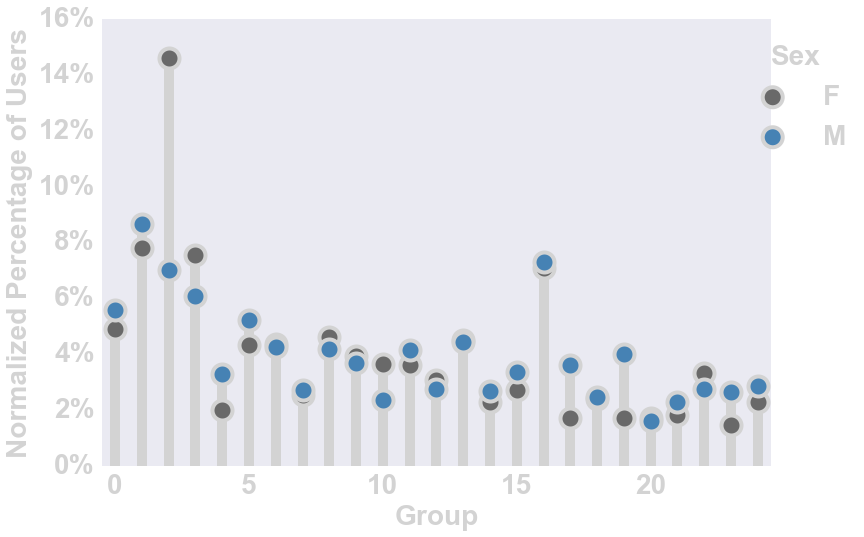

In [21]:
demog = 'sex'
subset = subset_df(df_4, demog, ['M', 'F'])
grouped = group_pct(subset, demog)
lollipop(grouped, demog, ['DimGray', 'SteelBlue'])

#### Superordinate

In [22]:
mask = df_4['group'].isin([10, 12, 17, 19])
movies = counts[np.array(mask), :]
movies = counts_by_class(movies, df_4[mask], 'sex',
                         one_vs_one=True, vals=['M', 'F'])
log_odds = log_odds_ratio(movies, vocab, use_variance=True)

In [23]:
print_terms(log_odds, 15)

star | star wars | wars | matrix | fight | park | fight club | man | dark knight | knight | pulp | godfather | trek | star trek | rings

love | girl | harry | potter | pride | prejudice | harry potter | pride prejudice | bones | girls | anatomy | jane | hunger games | grey 's | 's anatomy


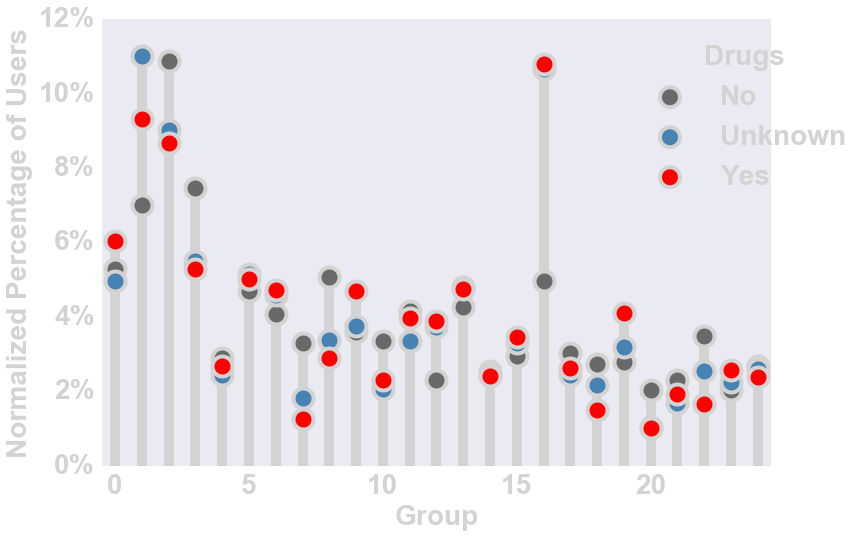

In [24]:
demog = 'drugs'
subset = subset_df(df_4, demog, ['yes', 'no', 'unknown'])
grouped = group_pct(subset, demog)
lollipop(grouped, demog, ['DimGray', 'SteelBlue', 'Red'])

## Predictive

In [25]:
def drug_labels(df):
    df = df.copy()
    labels = []
    for i in df.index:
        if df.drugs[i] in ('no', 'unknown'):
            labels.append(0)
        elif df.drugs[i] == 'yes':
            labels.append(1)
    return labels

In [26]:
df_4['labels'] = drug_labels(df_4)
drugs_yes = subset_df(df_4, 'drugs', ['yes'])
drugs_no = subset_df(df_4, 'drugs', ['no'])
drugs_known_sample = pd.concat([drugs_no.sample(drugs_yes.shape[0],
                                                random_state=42),
                                drugs_yes],
                               ignore_index=True)
drugs_unknown = subset_df(df_4, 'drugs', ['unknown'])

In [27]:
pred = {'vocabulary' : vocab}
_, known, _ = feature_vectors(drugs_known_sample.essay4, pred)
_, unknown, _ = feature_vectors(drugs_unknown.essay4, pred)

Note: still need cross validation.

In [28]:
model = LogisticRegression()
model.fit(known, drugs_known_sample['labels'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
yhat = model.predict(unknown)
yhat.sum() / len(yhat)

0.5496666385348975

In [30]:
drugs_unknown['yhat'] = yhat
drugs_unknown.groupby('group')['yhat'].mean().sort_values()

group
7     0.245370
20    0.276423
18    0.291829
8     0.332500
10    0.337398
22    0.338870
2     0.414566
11    0.446115
3     0.447005
17    0.468966
21    0.470000
4     0.479167
14    0.482877
24    0.521036
13    0.575439
0     0.588435
23    0.589552
6     0.592661
5     0.594108
9     0.614865
15    0.616368
1     0.630651
19    0.645503
12    0.669683
16    0.834652
Name: yhat, dtype: float64